# Transfer Learning and Fine Tuning for Wes

Transfer learning, adapted to Wes or Not Wes instead of dogs and cats. 
Base model is MobileNet V2.


https://www.tensorflow.org/tutorials/images/transfer_learning

Cats and dogs data structure 

```
train/ 
    cats/
        cat.835.jpg
    dogs/
        dog.157.jpg
validation/ 
    cats/
        cat.2273.jpg
    dogs/
        dog.2274.jpg
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
PATH = "/Users/rory/data/wes_anderson/data"

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

Found 2290 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

Found 1274 files belonging to 2 classes.


2024-11-08 15:55:06.664326: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


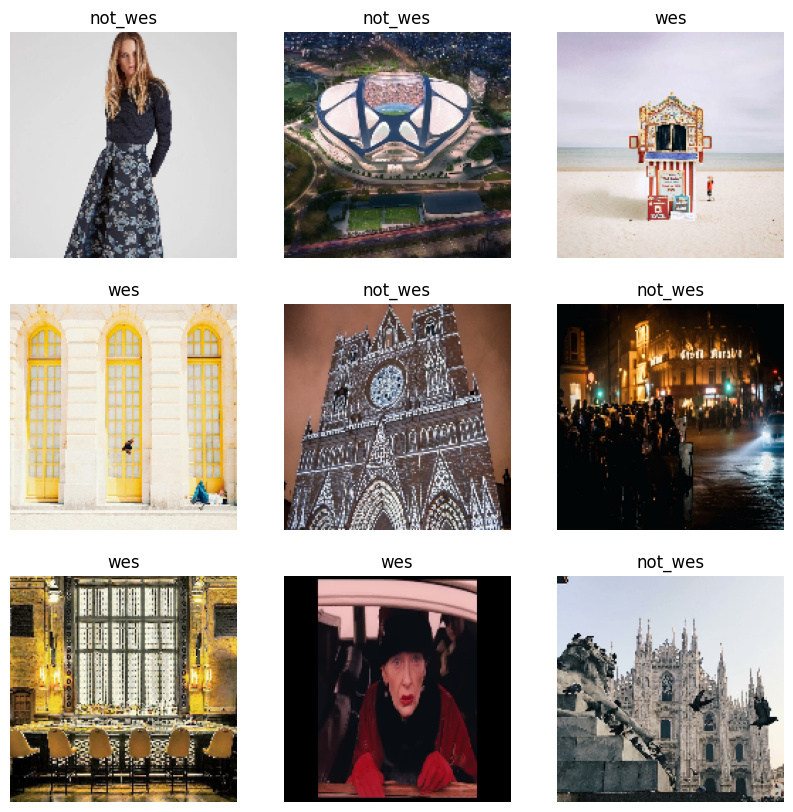

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 32
Number of test batches: 8


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

2024-11-08 15:55:13.158547: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


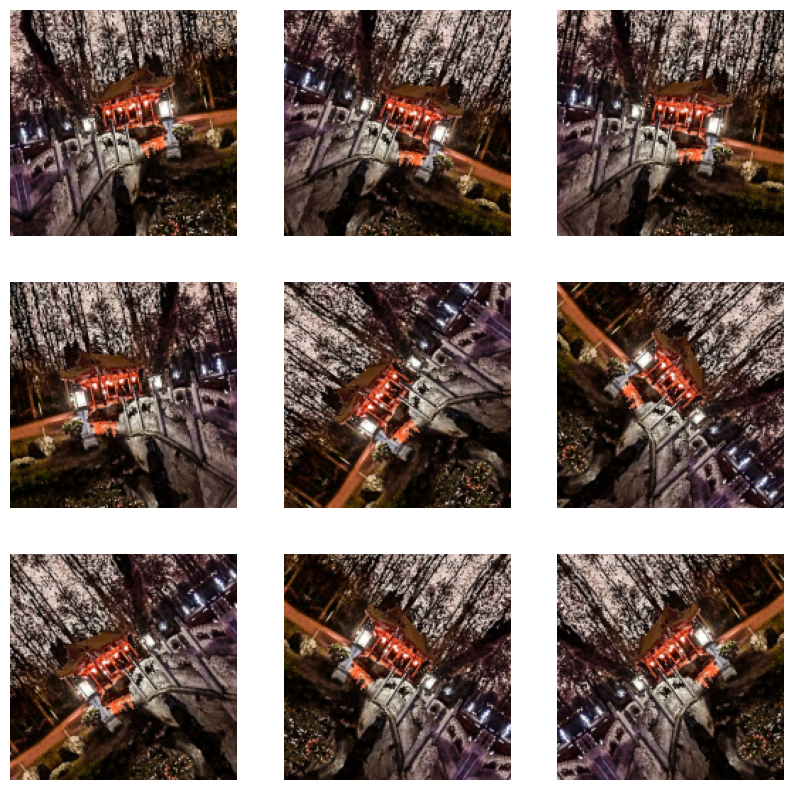

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
# base_model.summary()

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
len(model.trainable_variables)

2

In [20]:
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

In [21]:
loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.4914 - loss: 0.8115


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.49


## Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.
The loss should stabilize by the end of training. 

In [23]:
initial_epochs = 18


history = model.fit(
    train_dataset, epochs=initial_epochs, validation_data=validation_dataset
)

Epoch 1/18
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.4689 - loss: 0.8950 - val_accuracy: 0.5354 - val_loss: 0.7549
Epoch 2/18
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.5301 - loss: 0.7954 - val_accuracy: 0.5560 - val_loss: 0.7125
Epoch 3/18
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.5942 - loss: 0.7210 - val_accuracy: 0.5972 - val_loss: 0.6795
Epoch 4/18
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.5869 - loss: 0.7146 - val_accuracy: 0.6257 - val_loss: 0.6591
Epoch 5/18
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - accuracy: 0.6253 - loss: 0.6580 - val_accuracy: 0.6346 - val_loss: 0.6453
Epoch 6/18
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.6773 - loss: 0.6031 - val_accuracy: 0.6336 - val_loss: 0.6398
Epoch 7/18
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.6926 - loss: 0.5840 - val_accuracy: 0.6552 - val_loss: 0.6283
Epoch 8/18
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.7022 - loss: 0.5871 - val_accu

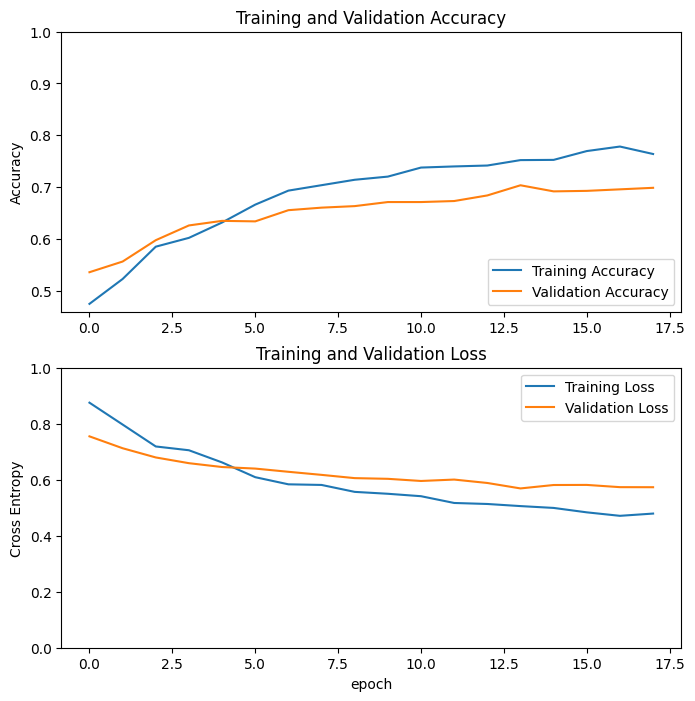

In [24]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [27]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

In [28]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [29]:
len(model.trainable_variables)

56

In [30]:
fine_tune_epochs = 18
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=validation_dataset,
)

Epoch 19/36
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 286ms/step - accuracy: 0.7288 - loss: 0.5373 - val_accuracy: 0.6847 - val_loss: 0.6126
Epoch 20/36
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - accuracy: 0.7828 - loss: 0.4578 - val_accuracy: 0.6945 - val_loss: 0.5984
Epoch 21/36
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step - accuracy: 0.8075 - loss: 0.4250 - val_accuracy: 0.7092 - val_loss: 0.5880
Epoch 22/36
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 0.8239 - loss: 0.3896 - val_accuracy: 0.7073 - val_loss: 0.5966
Epoch 23/36
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 316ms/step - accuracy: 0.8551 - loss: 0.3595 - val_accuracy: 0.7230 - val_loss: 0.5997
Epoch 24/36
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 0.8450 - loss: 0.3593 - val_accuracy: 0.7338 - val_loss: 0.5550
Epoch 25/36
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 315ms/step - accuracy: 0.8539 - loss: 0.3391 - val_accuracy: 0.7397 - val_loss: 0.5806
Epoch 26/36
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - accuracy: 0.8685 - loss: 0.3170 - 

In [31]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]
loss = history.history["loss"] + history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

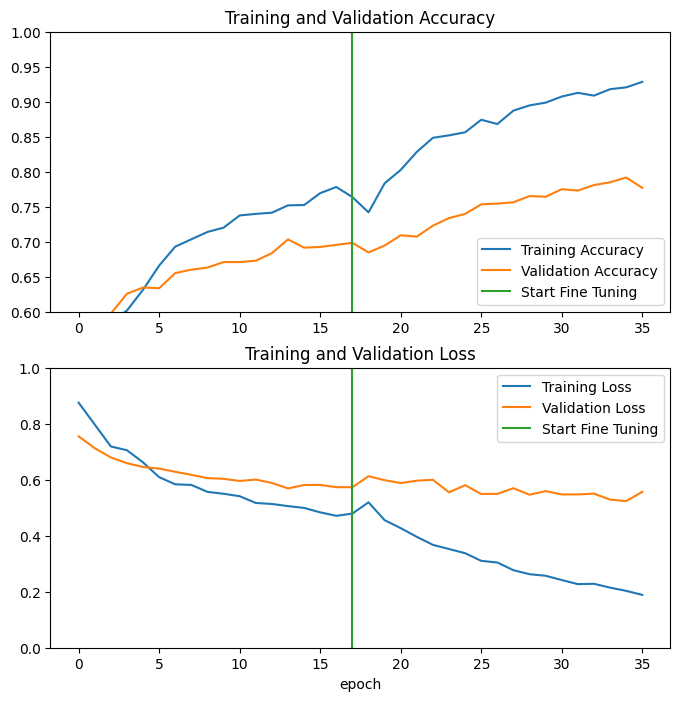

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.6, 1])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

## Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy :", accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.7783 - loss: 0.5042
Test accuracy : 0.7890625


Predictions:
 [0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1]
Labels:
 [0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1]


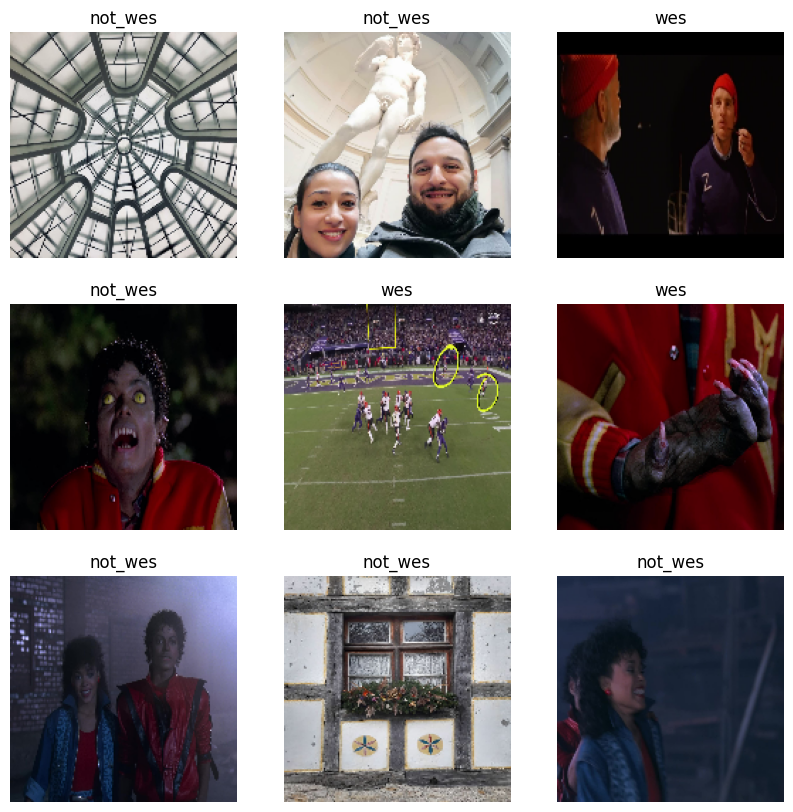

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [35]:
model.save("wes_mobilnetv2_transfer.keras")

In [37]:
!ls wes_mobilnetv2_transfer.keras

wes_mobilnetv2_transfer.keras


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = tflite_model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [39]:
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction, axis=1)
    return class_names[class_idx[0]]

In [40]:
predict_image("/Users/rory/Desktop/PXL_20240928_194742279.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


'not_wes'